了解深度学习需要熟悉许多简单的数学概念：张量、张量运算、微分、梯度下降等。我们在本章中的目标是在不过度技术化的情况下建立您对这些概念的直觉。特别是，我们将避免数学符号，对于那些没有任何数学背景的人来说，数学符号可能会令人反感，没有必要很好地解释事情。对数学运算最准确、最明确的描述是其可执行代码。

为了添加一些张量和梯度下降的上下文，我们将以神经网络的实例开始本章。然后，我们将逐点地检查引入的每个新概念。请记住，这些概念对于您理解以下章节中的实际示例至关重要！

阅读本章后，您将直观地理解深度学习背后的数学理论，并准备好开始深入了解Keras和TensorFlow.

# 2.1 A first look at a neural network

让我们看看一个使用Python库Keras学习手写数字分类的神经网络的具体示例。除非您已经有使用Keras或类似库的经验，否则您不会立即了解第一个示例的所有内容。你可能甚至还没有安装Keras；没关系。在下一章中，我们将回顾示例中的每个元素，并对其进行详细解释。因此，如果有些步骤在你看来是武断的或看起来像魔法，不要担心！我们必须从某个地方开始。

我们在这里试图解决的问题是将手写数字（28×28像素）的灰度图像分类为10个类别（0到9）。我们将使用MNIST数据集，这是机器学习社区的经典数据集，它几乎与该领域本身一样长，并经过了深入研究。这是一套6万张培训图像，外加1万张测试图像，由国家标准与技术研究所（MNIST中的NIST）在20世纪80年代组装而成。您可以将“解决”MNIST视为深度学习的“Hello World”——这是您验证算法是否正常工作的方法。当您成为机器学习从业者时，您将在科学论文、博客文章等中看到MNIST一次又一次地出现。您可以在图2.1中看到一些MNIST样本。


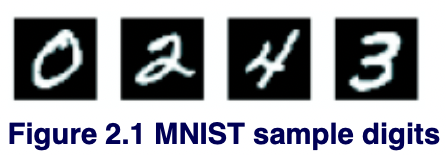

您现在不需要尝试在机器上重现此示例。如果您愿意，您首先需要设置一个深度学习工作区，该工作区将在第3章中介绍。

MNIST数据集以一组四个NumPy数组的形式在Keras中预加载。

In [1]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` 和 `train_labels` 构成了训练集，模型将从中学习的数据。然后，模型将在测试集、`test_images` 和 `test_labels` 上进行测试。图像编码为NumPy数组，标签是数字数组，从0到9不等。图像和标签有一对一的对应关系。

让我们看看训练数据：

In [2]:
train_images.shape

(60000, 28, 28)

In [3]:
len(train_labels)

60000

In [4]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

测试数据如下：

In [5]:
test_images.shape

(10000, 28, 28)

In [6]:
len(test_labels)

10000

In [7]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

工作流如下：首先，我们将向神经网络提供训练数据: `train_images` 和 `train_labels`。然后，网络将学习关联图像和标签。最后，我们将要求网络为`test_images` 生成预测，并将验证这些预测是否与 `test_labels` 的标签匹配。

让我们构建网络——再次记住，您还不能理解这个示例的所有内容。

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Metal device set to: Apple M1


2022-01-14 21:42:39.744464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-14 21:42:39.744817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


神经网络的核心构建块是层，这是一个数据处理模块，您可以将其视为数据过滤器。一些数据进入，并以更有用的形式出现。具体而言，图层从输入它们的数据中提取表示形式——希望这些表示形式对手头的问题更有意义。大多数深度学习包括将简单的层链接在一起，这些层将实现一种形式的渐进式数据蒸馏。深度学习模型就像一个数据处理的筛子，由一系列越来越精细的数据过滤器——层组成。

在这里，我们的模型由两个 Dense 层组成，这两个层是 Dense 连接（也称为全连接）的神经层。第二个（也是最后一个）层是一个10-way softmax 层，这意味着它将返回一个由10个概率分数组成的数组（总和为1）。每个分数将是当前数字图像属于我们10类之一的概率。

为了让模型为训练做好准备，我们需要再挑选三样东西，作为编译步骤的一部分:

- optimizer —— 该模型将根据它看到的训练数据行以下自我更新的机制的方式，以提高其性能。
- loss function —— 该模型将如何衡量其在训练数据上的性能，从而如何引导自己朝着正确的方向前进。
- Metrics to monitor during training and testing —— 在这里，我们只关心准确性（正确分类图像的一小部分）。

在接下来的两章中，损失函数和优化器的确切目的将明确。

In [9]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

在训练之前，我们将通过将其重塑为模型期望的形状并缩放数据来预处理数据，使所有值都在`[0,1]`区间内。例如，以前，我们的训练图像存储在uint8类型的形状数组（60000，28，28），值在 `[0,255]` 间隔内。我们将其转换为一个浮点32形状数组（60000，28*28），值在0到1之间。

In [10]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

我们现在准备训练模型，在Keras中，这是通过调用模型的 `fit` 方法完成的——我们将模型拟合其训练数据：

In [11]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

2022-01-14 21:42:40.009720: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-14 21:42:40.189975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.2596 - accuracy: 0.9240
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1053 - accuracy: 0.9685
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0698 - accuracy: 0.9793
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0504 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0375 - accuracy: 0.9885


训练期间显示两个数量：模型在训练数据上的丢失，模型在训练数据上的准确性。我们很快在训练数据上达到0.989（98.9%）的准确性。

现在我们有一个经过训练的模型，您可以使用它来预测新数字的类概率——这些图像不属于训练数据，如测试集中的图像：

In [12]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

2022-01-14 21:42:53.221735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([2.2527158e-10, 6.3516930e-12, 1.3177083e-07, 5.3897829e-06,
       6.3705568e-13, 5.1535829e-09, 6.6345746e-16, 9.9999440e-01,
       2.8604215e-09, 6.6672463e-08], dtype=float32)

该数组中的索引i的每个数量对应于数字图像 `test_digits[0]` 属于i类的概率。这个第一个测试数字在索引7中的概率得分最高（0.99999106，几乎1），所以根据我们的模型，它一定是7：

In [13]:
predictions[0].argmax()

7

In [14]:
predictions[0][7]

0.9999944

我们可以检查测试标签是否一致：

In [15]:
test_labels[0]

7

平均而言，我们的模型在对这些从未见过的数字进行分类方面有多好？让我们通过计算整个测试集的平均准确性来检查。

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc) 

 14/313 [>.............................] - ETA: 1s - loss: 0.0705 - accuracy: 0.9821 

2022-01-14 21:42:53.310108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step - loss: 0.0693 - accuracy: 0.9801
test_acc: 0.9801000356674194


测试集的准确性为97.8%——这比训练集的准确性（98.9%）要低得多。训练精度和测试精度之间的这种差距是过度拟合的一个例子：机器学习模型在新数据上的性能往往比训练数据的性能更差。过拟合是第3章的中心话题。

我们的第一个例子到此结束——您刚刚看到如何构建和训练神经网络，以在不到15行的Python代码中对手写数字进行分类。在这一章和下一章中，我们将详细介绍我们刚刚预览的每一件移动作品，并澄清幕后发生的事情。您将了解张量，进入模型的数据存储对象；张量操作，由哪些层组成；以及梯度下降，这允许您的模型从其训练示例中学习。

# 2.2 Data representations for neural networks

在前面的示例中，我们从存储在多维NumPy数组中的数据开始，也称为张量。一般来说，所有当前的机器学习系统都使用张量作为其基本数据结构。张量是该领域的基础——如此基本，以至于 Tensorflow 是以它们命名的。那么什么是张量？

在其核心，张量是数据的容器——通常是数字数据。所以，它是一个数字容器。您可能已经熟悉矩阵，它们是秩为2的张量：张量是矩阵到任意数量维度的推广（请注意，在张量上下文中，维度通常称为 `axis` ）。

## 2.2.1 Scalars (rank-0 tesnors)

仅包含一个数字的张量称为标量（或标量张量，或秩-0张量，或0D张量）。在NumPy中，float32或float64数字是标量张量（或标量数组）。您可以通过 `ndim` 属性显示NumPy张量的轴数；标量张量有0个轴（ndim == 0）。张量的轴数也称为秩。这是一个NumPy标量：

In [17]:
import numpy as np
x = np.array(12)
x

array(12)

In [18]:
x.ndim

0

## 2.2.2 Vectors (rank-1 tensors)

数字数组称为矢量、秩-1张量或1D张量。一级张量正好有一个轴。以下是NumPy矢量：

In [19]:
x =  np.array([12, 3, 6, 14, 7])
x

array([12,  3,  6, 14,  7])

In [20]:
x.ndim

1

这个矢量有五个条目，因此被称为五维矢量。不要将5D矢量与5D张量混淆！5D矢量只有一个轴，沿轴有五个维度，而5D张量有五个轴（每个轴上可能有任意数量的维度）。维度可以表示沿特定轴的条目数量（如我们的5D矢量）或张量中的轴数（如5D张量），这有时可能会令人困惑。在后一种情况下，谈论秩为5的张量（张量的秩是轴数）在技术上更正确，但模棱两可的符号5D张量无论如何都很常见。

## 2.2.3 Matrices (rank-2 tensors)

矢量数组是矩阵、秩-2张量或二维张量。矩阵有两个轴（通常指行和列）。您可以直观地将矩阵解释为矩形数字网格。这是一个NumPy矩阵：

In [21]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
x.ndim

2

来自第一轴的条目称为行，来自第二轴的条目称为列。在前面的示例中，[5、78、2、34、0]是x的第一行，[5、6、7]是第一列。

## 2.2.4 Rank-3 tensors and higher-rank tensors

如果您将此类矩阵打包在新数组中，您将获得秩-3张量（或3D张量），您可以直观地将其解释为数字立方体。以下是NumPy秩-3张量：

In [22]:
x = np.array([[[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]]])
x.ndim

3

通过在数组中打包秩-3张量，您可以创建一个秩4张量，依此类推。在深度学习中，您通常会操作秩为0到4的张量，但如果您处理视频数据，可能会达到5级。

## 2.2.5 Key attributes

- Number of axes (rank) —— 例如，秩-3张量有三个轴，矩阵有两个轴。在NumPy或TensorFlow等Python库中，这也被称为张量的ndim。
- Shape —— 他的是一个整数元组，描述了张量沿着每个轴的维度。例如，前面的矩阵示例有形状（3，5），秩-3张量示例有形状（3，3，5）。矢量具有具有单个元素的形状，例如（5），而标量具有空形状，（）。
- Data type (usually called dtype in Python libraries) —— 这是张量中包含的数据类型；例如，张量的类型可以float16、float32、float64、uint8等。在TensorFlow中，您还可能会遇到字符串张量。

为了使这一点更加具体，让我们回顾一下我们在MNIST示例中处理的数据。首先，我们加载MNIST数据集：

In [23]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


接下来，我们显示张量 `train_images` 的轴数，`ndim` 属性：

In [24]:
print(train_images.ndim)

3


这是它的形状：

In [25]:
print(train_images.shape)

(60000, 28, 28)


这是它的数据类型，dtype属性：

In [26]:
print(train_images.dtype)

uint8


因此，我们这里有一个8位整型的秩-3张量。更准确地说，这是一个由6万个矩阵组成的数组，共28×28个整数。每个这样的矩阵都是灰度图像，系数在0到255之间。

让我们使用库Matplotlib（标准科学Python套件的一部分）显示此秩-3张量中的第四位数字；见图2.2

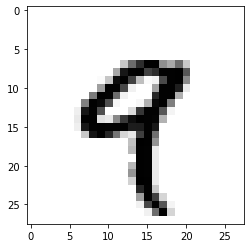

In [27]:
digit = train_images[4]
import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

当然，相应的标签是整数9：

In [28]:
train_labels[4]

9

## 2.2.6 Manipulating tensors in NumPy

在前面的示例中，我们使用语法 `train_images[i]` 在第一个轴旁边选择了特定数字。在张量中选择特定元素称为张量切片。让我们看看你可以在NumPy数组上执行的张量切片操作。

以下示例选择数字 `#10` 到 `#100`（不包括 `#100`），并将其置于形状为（90、28、28）的数组中：

In [29]:
my_slice = train_images[10:100]
print(my_slice.shape)

(90, 28, 28)


它相当于这个更详细的符号，它指定了沿每个张量轴切片的开始索引和停止索引。请注意：相当于选择整个轴：

In [30]:
my_slice = train_images[10:100, :, :]
my_slice.shape

(90, 28, 28)

In [31]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

(90, 28, 28)

一般来说，您可以沿着每个张量轴在任何两个索引中进行选择。例如，为了在所有图像的右下角选择14×14像素，您可以这样做：

In [32]:
my_slice = train_images[:, 14:, 14:]

也可以使用负索引。与Python列表中的负索引非常相似，它们表示相对于当前轴末端的位置。为了将图像裁剪为以中间为中心的14×14像素的patch，您可以这样做：

In [33]:
my_slice = train_images[:, 7:-7, 7:-7]

## 2.2.7 The notion of data batches

一般来说，您在深度学习中遇到的所有数据张量中的第一个轴（轴0，因为索引从0开始）将是样本轴（有时称为样本维度）。在MNIST示例中，样本是数字图像。

此外，深度学习模型不会同时处理整个数据集；它们会被拆成多个小批量。 具体而言，这是我们一个小批量 MNIST 数字，批量大小为128：

In [34]:
batch = train_images[:128]

接下来是另一个小批量：

In [35]:
batch = train_images[128:256]

第 n 个小批量：

In [36]:
n = 3
batch = train_images[128 * n: 128 * (n + 1)]

在考虑这种批处理张量时，第一轴（轴0）称为批处理轴或批处理维度。这是您在使用Keras和其他深度学习库时经常遇到的术语。

## 2.2.8 Real-world examples of data tensors

让我们用几个与您以后会遇到的类似的例子来使数据张量更加具体。您将操作的数据几乎总是属于以下类别之一：

- Vector data —— 秩-2 张量的形状 (samples, features)
- Timeseries data or sequence data — 秩-3 张量的形状 (samples, timesteps, features)
- Images — 秩-4 张量的形状 (samples, height, width, channels) 或者 (samples, channels, height, width)
- Video — 秩-5 张量的形状 (samples, frames, height, width, channels) 或者 (samples, frames, channels, height, width)

## 2.2.9 Vector data

这是最常见的情况之一。在这样的数据集中，每个数据点都可以编码为矢量，因此一批数据将被编码为秩-2张量（即矢量数组），其中第一个轴是样本轴，第二个轴是特征轴。

让我们来看两个例子：

- 人的数据集，我们考虑每个人的年龄、邮政编码和收入。每个人都可以被描述为3个值的矢量，因此10万人的完整数据集可以存储在形状为（100000，3）的 秩-2 张量。
- 文本文档的数据集，我们通过计算每个单词在文档中的出现次数来表示每个文档（来自20,000个常用单词的字典）。每个文档都可以编码为20,000个值的矢量（字典中每个单词一个计数），因此一个由500个文档组成的整个数据集可以存储在形状张量中（500，20000）。

## 2.2.10 Timeseries data or sequence data

每当时间在您的数据（或序列顺序的概念）中很重要时，将其存储在带有显式时间轴的秩-3张量中是有道理的。每个样本都可以编码为矢量序列（秩-2张量），因此一批数据将被编码为秩-3张量（见图2.3）。

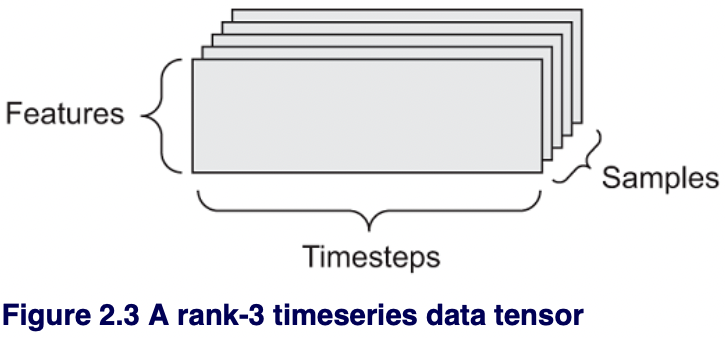

按照惯例，时间轴始终是第二轴（索引1的轴）。让我们看看几个例子：

- 股价数据集。每分钟，我们都会存储股票的当前价格，过去一分钟的最高价格，过去一分钟的最低价格。因此，每分钟都被编码为3D矢量，一整天的交易被编码为形状为（390，3）的矩阵（交易日有390分钟），250天的数据可以存储在形状为（250，390，3）的秩3张量。在这里，每个样本都是一天的数据。
- 推文数据集，我们将每条推文编码为128个唯一字符的字母表中的280个字符序列。在此设置中，每个字符都可以编码为大小为128的二进制矢量（除字符对应索引处的1个条目外，这是一个全零矢量）。然后，每条推文都可以编码为形状为（280，128）的秩-2张量，100万条推文的数据集可以存储在形状为（1000000，280，128）的张量。

## Image data

图像通常有三维：高度、宽度和颜色深度。虽然灰度图像（像我们的MNIST数字一样）只有一个颜色通道，因此可以存储在2级张量中，但根据惯例，图像张量总是3-rank，灰度图像有一个一维颜色通道。因此，一批尺寸为256×256的128张灰度图像可以存储在形状张量（128、256、256、1）中，一批128张彩色图像可以存储在形状张量（128、256、256、3）中（见图2.4）。

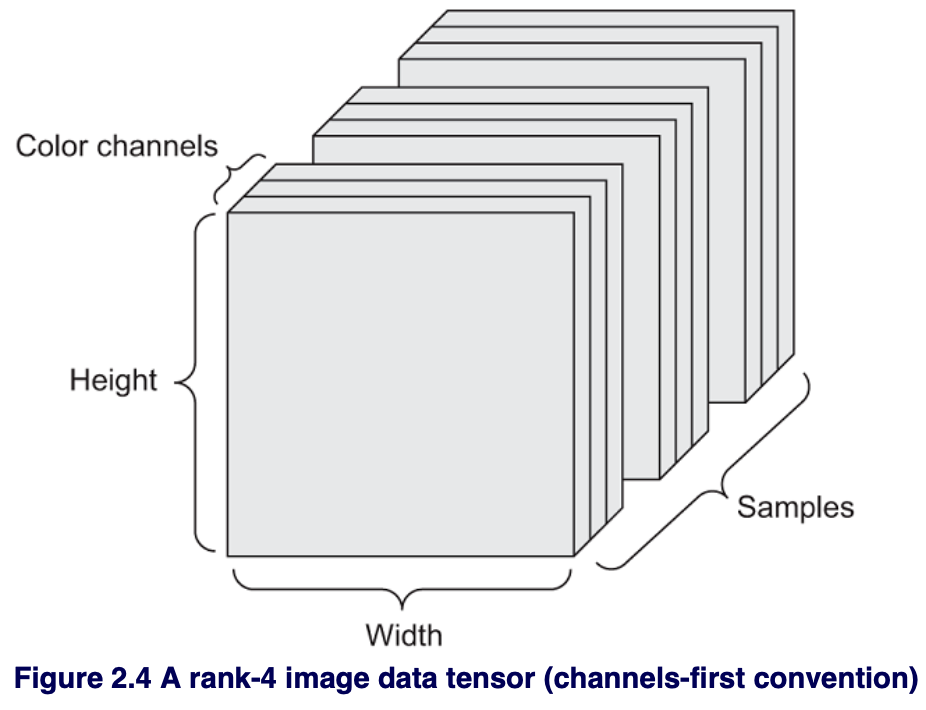

图像张量形状有两种约定：*channels-last* 约定（这是TensorFlow的标准）和 *channels-first* 约定。

*channels-last* 约定将颜色深度轴放在末尾：（样本、高度、宽度、颜色深度）。同时，*channels-first* 约定将颜色深度轴紧放在批处理轴之后：（样本、颜色深度、高度、宽度）。有了最后一个通道约定，前面的例子将成为（128、1、256、256）和（128、3、256、256）。Keras API同时支持这两种格式。

## 2.2.12 Video data

视频数据是少数几种需要秩-5张量的真实世界数据类型之一。视频可以理解为帧序列，每个帧都是彩色图像。由于每个帧可以存储在秩-3张量（高度、宽度、颜色深度）中，因此一系列帧可以存储在秩-4张量（帧、高度、宽度、颜色深度）中，因此一批不同的视频可以存储在形状的秩-5张量（样本、帧、高度、宽度、颜色深度）。

例如，以每秒4帧的速度采样的60秒144×256个YouTube视频片段将有240帧。一批四个这样的视频剪辑将以形状的张量（4、240、144、256、3）存储。这总共有106,168,320个值！如果张量的dtype是float32，那么每个值将存储在32位中，因此张量将代表405 MB。重！您在现实生活中遇到的视频要轻得多，因为它们不存储在float32中，并且通常被（例如MPEG格式）压缩。

# 2.3 The gears of neural networks: tensor operations

正如任何计算机程序最终可以简化为二进制输入（AND、OR、NOR等）上的一小组二进制运算一样，深度神经网络学到的所有转换都可以简化为应用于数值数据的张量运算。例如，可以张量加法、张量乘法等。

在我们最初的示例中，我们通过将 Dense 层叠加在一起来构建模型。Keras层实例如下所示：

In [38]:
import keras
keras.layers.Dense(512, activation='relu')

此层可以解释为函数，该函数将矩阵作为输入，并返回另一个矩阵——输入张量的新表示形式。具体而言，函数如下（其中W是矩阵，b是矢量，两者都是图层的属性）：

In [ ]:
output = relu(dot(w, input) + b)

我们打开这个。我们这里有三个张量运算：input 张量 和 名为W的张量之间的点积（dit）；生成的矩阵和矢量b之间的加法（+）；以及最后，relu运算。`relu(x)`是max（x，0）。

## Element-wise operations

`relu` 操作 和 加法 是 element-wise 的操作：独立应用于所考虑张量中每个条目的操作。这意味着这些操作非常适合大规模并行实现（矢量化实现，这个词来自1970-1990年期间的矢量处理器超级计算机架构）。如果您想编写元素操作的朴素的Python实现，请使用for循环，就像 element-wise `relu` 操作的朴素实现一样：

In [40]:
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

- x 为秩-2 numpy 张量
- 避免重写 input 张量

对于加法你同样可以操作如下：

In [42]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

根据同一原理，您可以进行元素乘法、减法等。

在实践中，在处理NumPy数组时，这些操作是可用的，以及优化的内置NumPy函数，如果您安装了NumPy函数（您应该这样做），这些函数本身会将繁重的任务委托给Basic Linear Algebra Subprograms（BLAS）实现。BLAS是低级、高度并行、高效的张量操作例程，通常在Fortran或C中实现。

因此，在NumPy中，您可以执行以下元素操作，这将非常快速：

In [ ]:
import numpy as np
z= x + y
z = np.maximum(z, 0.)

让我们比较它们所花费的时间：

In [46]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: %.2f s" % (time.time() - t0))

Took: 0.01 s


这需要0.02秒。与此同时，朴素的版本需要令人惊叹的2.45s：

In [47]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print('Took: %.2f s' % (time.time() - t0))

Took: 1.23 s


同样，在GPU上运行TensorFlow代码时，元素操作通过全矢量CUDA实现执行，该实现可以最好地利用高度并行的GPU芯片架构。

## 2.3.2 Broadcasting

我们早期对 `naive_add` 的幼稚实现只支持添加形状相同的rank-2张量。但在前面介绍的 Dense 层中，我们添加了一个带有矢量的秩-2张量。当形状不同的两个张量相加时，会发生什么？

在可能的情况下，如果没有歧义，将广播较小的张量，以匹配较大张量的形状。广播由两个步骤组成：

- 给较小的张量增加轴（称为广播轴），以匹配较大张量的ndim。
- 较小的张量沿着新轴重复，以匹配较大张量的完整形状。

让我们看看一个具体的例子。考虑形状（32，10）的 $x$ 和形状（10，）的 $y$。首先，我们在 $y$ 中添加一个空的第一轴，其形状变成了（1，10）。然后，我们沿着这个新轴重复 $y$ 32次，这样我们最终会得到一个形状（32，10）的张量 $Y$，其中 $Y[i，:] == y for i in range(0，32)$。此时，我们可以继续加 $x$ 和 $y$，因为它们的形状相同。

在实现方面，没有创建新的rank-2张量，因为这将非常低效。重复操作是完全虚拟的：它发生在算法级别，而不是内存级别。但考虑到矢量与新轴一起重复10次是一个有用的 mental 模型。朴素的实现如下：

In [48]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

对于广播，如果一个张量的形状为 (a, b, ..., n, n + 1, ..., m)，另一个张量的形状为 (n, n + 1, ..., m)， 您通常可以应用两个张量的 element-wise操作。 然后，轴a到n-1的广播将自动进行。

以下示例通过广播将元素最大操作应用于两个不同形状的张量：

In [49]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)

## Tensor product

张量积或点积（不要与 element-wise 的积 * 运算符混淆）是最常见、最有用的张量运算符之一。

在NumPy中，张量积使用np.dot函数完成（因为张量积的数学符号通常是一个点）。

In [50]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)

在数学符号中，您将用点（•）记作操作：

In [ ]:
z = x · y

从数学上讲，点积运算是做什么的？让我们从两个矢量x和y的点积开始。它的计算如下：

In [53]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

x 和 y 是 Numpy 矢量

您会注意到，两个矢量之间的点积是一个标量，只有元素数量相同的矢量才能与点积兼容。

您还可以在矩阵x和矢量y之间使用点积。 你可以实现如下：

In [55]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

您还可以重用我们之前编写的代码，该代码强调了矩阵向量积和向量积之间的关系：

In [56]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

请注意，一旦两个张量中的一个ndim大于1，点积就不再对称了，也就是说点积(x，y)与点积(y，x)不同。

当然，点积推广到任意数量轴的张量。最常见的应用程序可能是两个矩阵之间的点积。如果且仅当 `x.shape[1] == y.shape[0]` ，您才能获取两个矩阵 $x$ 和 $y$（dot(x，y)）的点积。结果是一个形状为 (x.shape[0]，y.shape[1]) 的矩阵，其中系数是 $x$ 行 和 $y$ 列之间的矢量乘积。以下是朴素的实现：

In [57]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

为了了解点积的形状，如图2.5所示，通过对齐输入和输出张量来帮助可视化它们。

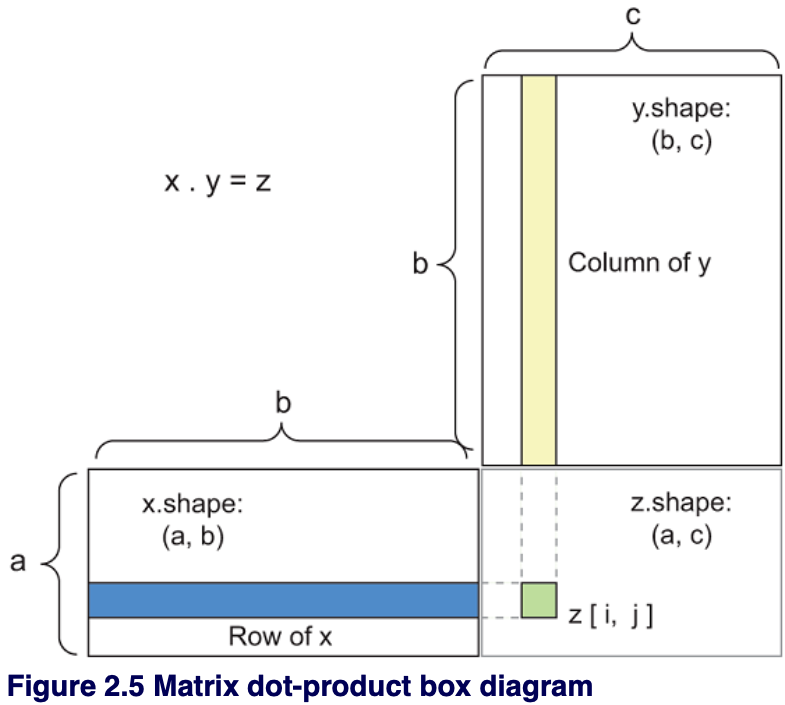

$x$、$y$和 $z$ 被描绘成矩形。由于 $x$ 的行 和 $y$ 的列的大小必须相同，因此 $x$ 的宽度必须与 $y$ 的高度匹配。如果您继续开发新的机器学习算法，您可能会经常绘制此类图表。

更一般地说，您可以在高维张量之间取点积，遵循前面为2D案例概述的形状兼容性规则：

```
(a, b, c, d) • (d,) -> (a, b, c)
(a, b, c, d) • (d, e) -> (a, b, c, e)
```

以此类推

## 2.3.4 Tensor reshaping

第三种对理解至关重要的张量运算是张量重塑。虽然在我们第一个神经网络示例的 Dense 层中没有使用它，但我们在将数字数据输入模型之前对其进行了预处理时使用了它：

In [58]:
train_images = train_images.reshape((60000, 28 * 28))

重塑张量意味着重新排列其行和列以匹配目标形状。当然，重塑张量的系数总数与初始张量相同。重塑最好通过简单的示例来理解：

In [59]:
x = np.array([[0., 1.],
              [2., 3.],
              [4., 5.]])

In [60]:
print(x.shape)

(3, 2)


In [61]:
x = x.reshape((6, 1))

In [62]:
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [63]:
x = x.reshape((2, 3))
x

array([[0., 1., 2.],
       [3., 4., 5.]])

通常遇到的重塑的一个特殊情况是 *transposition*。转置矩阵意味着交换其行和列，以便 `x[i，:]` 变成 `x[:, i]`：

In [64]:
x = np.zeros((300, 200))
x = np.transpose(x)
print(x.shape)

(200, 300)


## 2.3.5 Geometric interpretation of tensor operations

由于张量运算操作的张量内容可以解释为某些几何空间中点的坐标，因此所有张量操作都有几何解释。例如，让我们考虑添加。我们将从以下矢量开始：

In [65]:
A = [0.5, 1]

这是2D空间中的一个点（见图2.6）。如图2.7所示，通常将矢量描绘成连接原点的箭头。

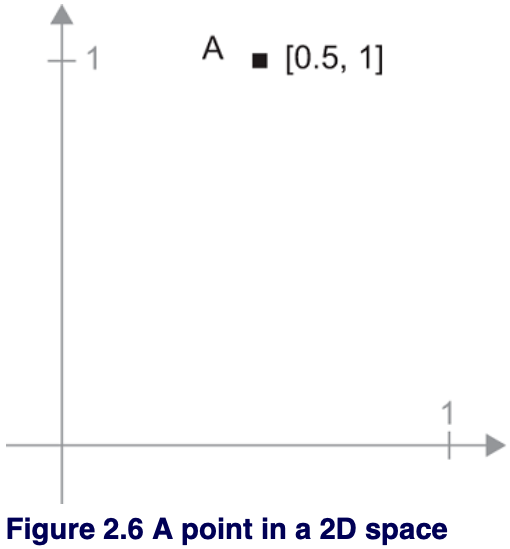

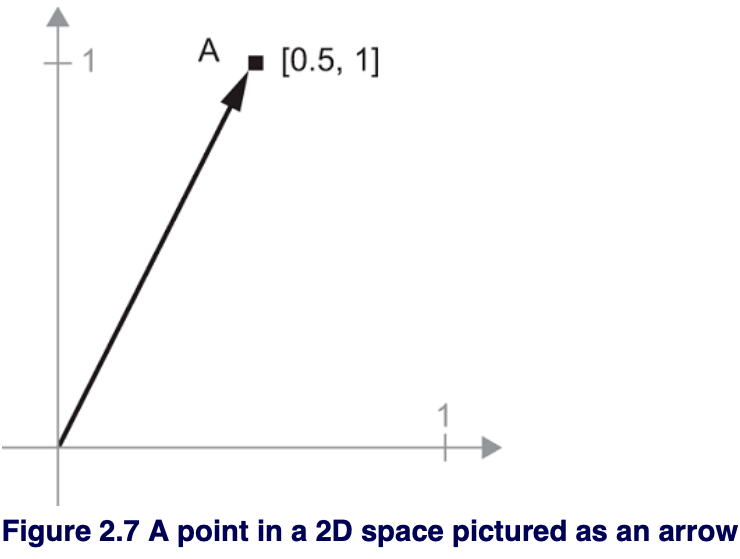

让我们考虑一个新的点，B = [1, 0.25]，我们将添加到上一个点中。这是通过将矢量箭头链接在一起来几何方式完成的，由此产生的位置是代表前两个矢量之和的矢量（见图2.8）。

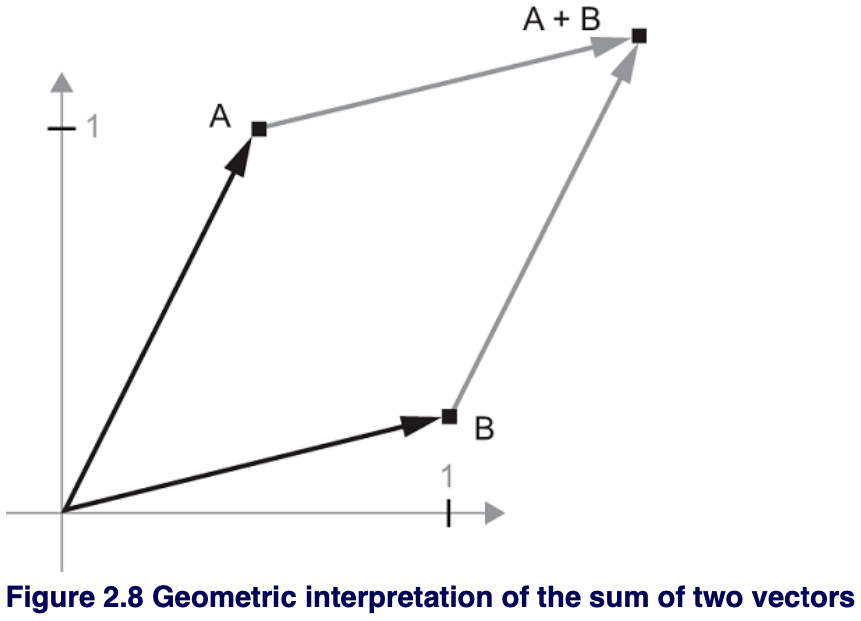

一般来说，平移、旋转、缩放、倾斜等基本几何运算可以表示为张量运算。这里有几个例子。

- *Translation*： 正如您刚刚看到的，向点添加矢量将使该点朝着固定方向移动固定数量。应用于一组点（如2D对象），这被称为“translation”

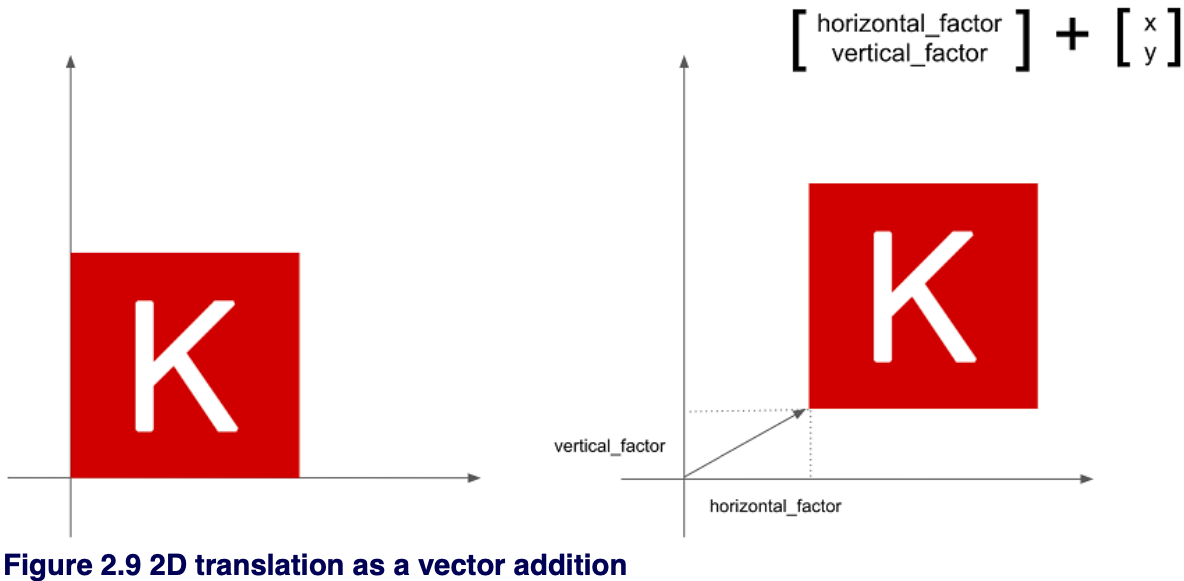

- *Rotation:*： 2D矢量按角度θ旋转可以通过具有2×2矩阵 $R = [[\cos(theta), \sin(theta)], [-\sin(theta), \cos(theta)]]$ 的点积来实现。

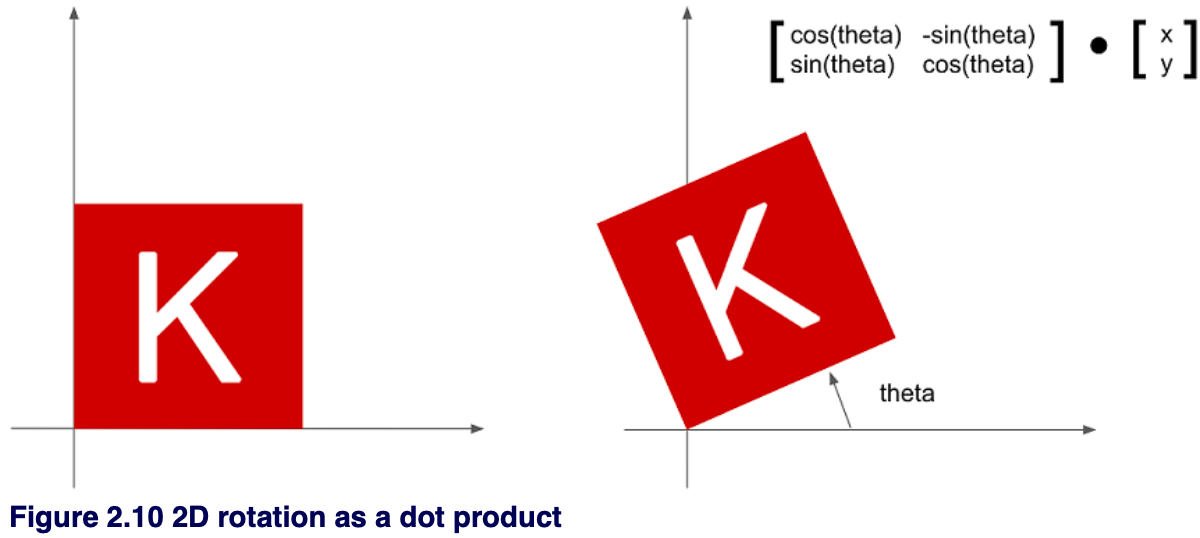

- *Scaling*:图像的垂直和水平缩放可以通过具有2 x 2矩阵的点积来实现 S =（请注意，这种矩阵被称为“对角矩阵”，因为它的“对角线”中只有非零系数，从左上角到右下角）。

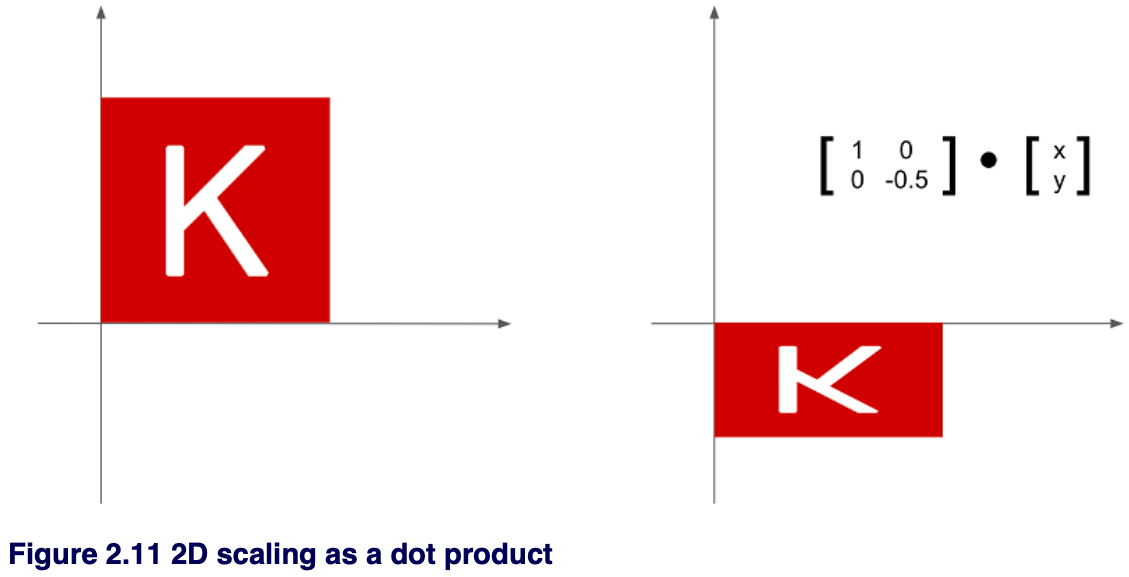

- *Linear transform:* 具有任意矩阵的点积实现线性变换。请注意，如上所述，缩放和旋转顾名思义是线性变换。
- *Affine transform:* 仿射变换是线性变换（通过一些矩阵的点积实现）和平移（通过矢量加法实现）的组合。您可能已经认识到，这正是 Dense 层实现的y = W • x + b计算！没有激活函数的 Dense层是 affine 层。

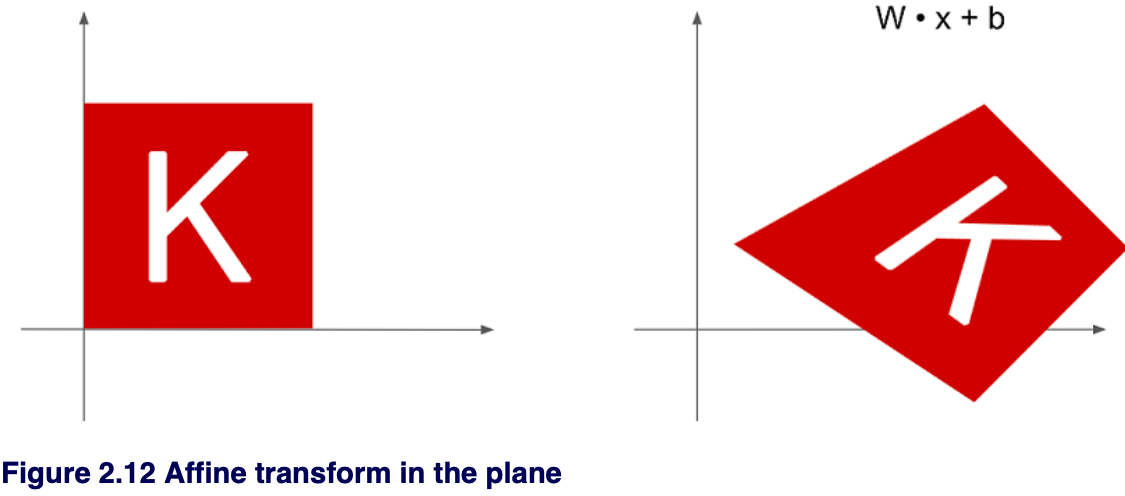

- *Dense layer with relu activation:* 关于仿射变换的一个重要观察是，如果您重复应用其多次，您最终得到的仍然是一个仿射变换（因此它等价于一开始就使用一个仿射变换）。让我们用两个来尝试：affine2(affine1(x)) = W2 • (W1 • x + b1) + b2 = (W2 • Wa) • x + (W2 • b1 + b2)。这是一个仿射变换，线性部分是矩阵 W2 · W1，平移部分是矢量 W2 · b1 + b2。因此，完全由不激活的 Dense 层组成的多层神经网络将等同于单个 Dense 层。这个“深”神经网络只是一个变相的线性模型！这就是为什么我们需要激活函数，如relu。多亏了激活函数，可以形成一个 Dense层链 来实现非常复杂、非线性的几何变换，从而为您的深度神经网络提供非常丰富的假设空间。我们在下一章中更详细地介绍这个想法。

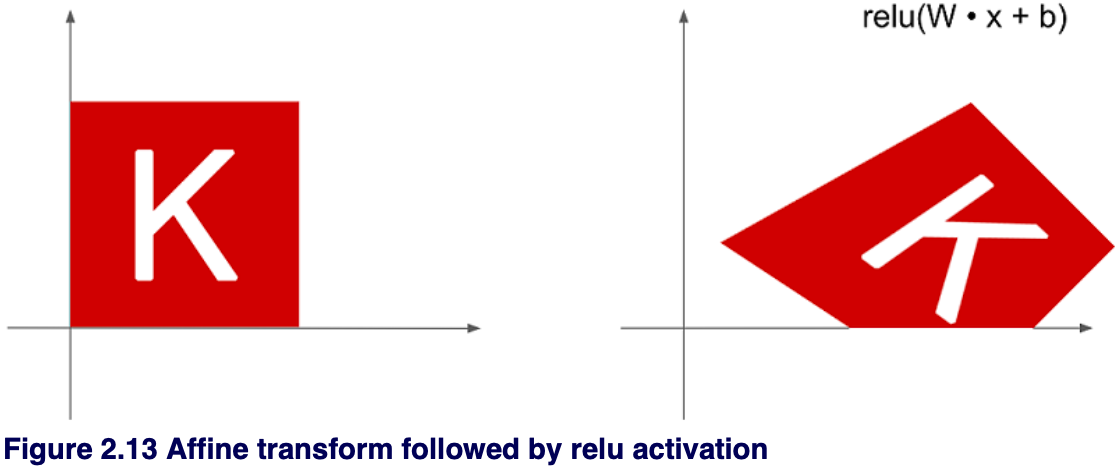

## 2.3.6 A geometric interpretation of deep learning

您刚刚了解到，神经网络完全由张量运算链组成，所有这些张量运算只是输入数据的简单几何变换。因此，您可以将神经网络解释为高维空间中非常复杂的几何变换，通过一系列简单的步骤实现。

在3D中，想象一下两张彩色纸：一张红色，一张蓝色。把一个放在另一个上面。现在把它们揉成一个小球。那个皱巴巴的纸球是你的输入数据，每张纸都是分类问题中的一类数据。神经网络（或任何其他机器学习模型）打算做的是弄清楚纸球的变换，使其展开，以使两个类再次干净分离。通过深度学习，这将实现为3D空间的一系列简单变换，例如你可以用手指在纸球上一次一个动作地应用的变换。

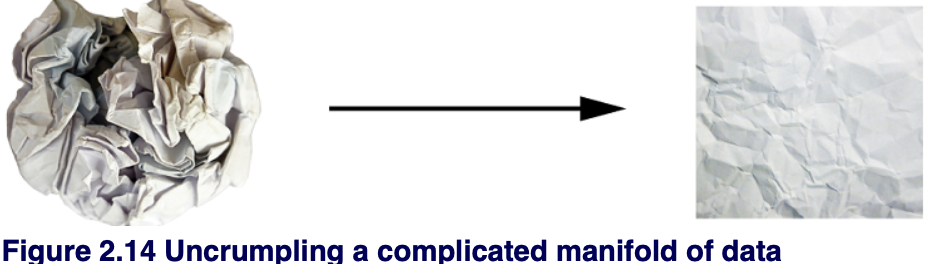

展开纸球是机器学习的意义：为复杂、高度折叠的数据流形找到整洁的表示形式。在这一点上，你应该对为什么深度学习擅长这一点有一个很好的直觉：它采取将复杂的几何变换成一长串基本的渐进的方法，这几乎是人类解开纸球的策略。深度网络中的每个层都应用了一个略微解开数据的转换——深层堆栈使一个极其复杂的解开过程变得易于处理。

# 2.4 The engine of neural networks: gradient-based optimization

正如您在上一节中看到的，我们第一个模型示例中的每个神经层都按如下方式变换其输入数据：

```python
output = relu(dot(W, input) + b)
```

在这个表达式中，W 和 b是张量， 其是 layer 的属性。它们被称为 layer 的权重或可训练参数（分别为 `kernel` 属性和 `bias` 属性）。这些权重包含模型从接触训练数据中学到的信息。

最初，这些权重矩阵充满了小的随机值（一个称为随机初始化的步骤）。当然，当W和b是随机的时，没有理由期望relu（dot（W，input）+ b）会产生任何有用的表示。由此产生的表示毫无意义——但它们是一个起点。接下来是根据反馈信号逐步调整这些权重。这种渐进的调整，也称为训练，基本上是机器学习的学习。

这发生在所谓的训练循环中，工作原理如下。再循环中重复这些步骤， 直到 loss 足够低：

- 从训练样本中采样一批 `x` 和对应的标签 `y_true`
- 对 `x` 运行模型 (一个 step 叫做 forward pass) 得到预测 `y_pred`
- 对批量计算模型的 loss， 其用来度量 `y_pred` 和 `y_true` 的不匹配程度
- 更新模型的所有权重以减少这个批量上的 loss

您最终将得到一个训练数据损失非常低的模型：预测 `y_pred` 和预期目标 `y_true` 之间的低不匹配。该模型已“学习”将其输入映射到正确的目标。从远处看，它可能看起来像魔法，但当你把它简化为基本步骤时，结果很简单。

第1步听起来很简单——只有I/O代码。第2步和第3步只是少数张量运算的应用，因此您可以完全根据您在上一节中学到的知识来实现这些步骤。困难的部分是第4步：更新模型的权重。给定模型中的单个权重系数，您如何计算该系数是应该增加还是减少，以及增加多少？

一个朴素的解决方案是冻结模型中除考虑的一个标量系数外的所有权重，并尝试该系数的不同值。假设系数的初始值是0.3。向前传递一批数据后，批处理上的模型丢失率为0.5。如果您将系数的值更改为0.35并重新运行正向传递，损失将增加到0.6。但如果你把系数降低到0.25，损失就会下降到0.4。在这种情况下，似乎将系数更新为-0.05将有助于最大限度地减少损失。这必须对模型中的所有系数重复。

但这种方法将非常低效，因为您需要为每个单独的系数（其中有许多，通常是数千个，有时高达数百万个）计算两个forward pass（价格昂贵）。一个更好的方法是利用模型中使用的所有操作都是可微的这一事实，并计算模型系数的损失梯度。然后，您可以将系数（在一次更新中一次性移动，而不是一次移动一次）向梯度相反的方向移动，从而减少损失。

## 2.4.1 What’s a derivative?

考虑一个连续、光滑的函数 $f(x) = y$ ，将数字 $x$ 映射到新数字 $y$ 。由于函数是连续的，$x$ 中的小变化只能导致 $y$ 中的小变化——这就是连续性背后的直觉。假设您将 $x$ 增加一个小因子 epsilon_x ：这会导致$y$ 上有一个小的 epsilon_y 变化 ：

```python
f(x + epsilon_x) = y + epsilon_y
```

此外，由于函数是光滑的（其曲线没有任何突然的角度），当 epsilon_x 足够小时，围绕某个点 $p$ ，可以近似 $f$ 作为斜率 $a$ 的线性函数，以便 epsilon_y 成为 $a * epsilon_x$：

```python
f(x + epsilon_x) = y + a * epsilon_x
```

显然，只有当 $x$ 足够接近 $p$ 时，这种线性近似才有效。

斜率 $a$ 在 $p$ 中被称为 $f$ 的导数。如果 $a$ 是负数，这意味着 $p$ 周围的 $x$ 小幅变化将导致 $f(x)$ 的减少（如图2.10所示）；如果 $a$ 是正数，$x$ 的微小变化将导致 $f(x)$ 的增加。此外，$a$（导数的大小）的绝对值告诉你这种增减的速度有多快。

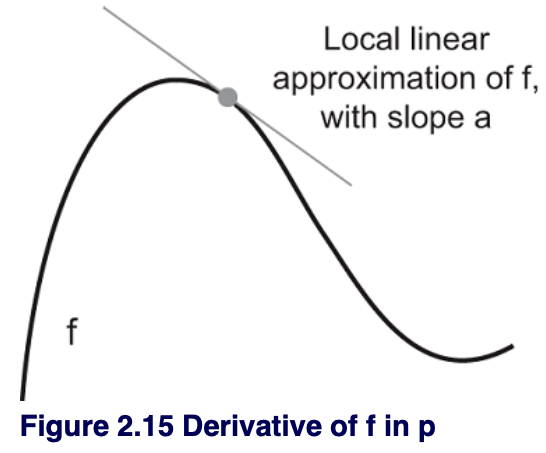

对于每个可微函数 $f(x)$（可微 表示“可导”：例如，光滑、连续函数可导），存在一个导数函数 $f'(x)$ ，将 $x$ 的值映射到这些点中f的局部线性近似的斜率。例如，$\cos(x)$ 的导数是 $-\sin(x)$，$f(x) = a * x$ 的导数是 $f'(x) = a$，依此类推。

如果您试图以 epsilon_x 为因子更新 $x$ 以最小化 $f(x)$，并且您知道 $f$ 的导数，那么您的工作就完成了：导数完全描述了 $f(x)$ 如何随着您更改 $x$ 而演变。如果你想降低 $f(x)$ 的值，你只需要向导数向相反的方向移动 $x$。

## 2.4.2 Derivative of a tensor operation: the gradient

梯度是张量运算的导数。这是导数概念对多维输入函数的推广：即以张量为输入的函数。

考虑输入矢量 x、矩阵 W、目标 y_true 和损失函数 `loss`。您可以使用 W 计算目标候选 y_pred，并计算目标候选 y_pred 和目标 y_true 之间的损失或不匹配：

```python
y_pred = dot(W, x)
loss_value = loss(y_pred, y_true)
```

如果数据输入 x 和 y_true 被冻结，那么这可以解释为 W 的函数映射值到损失值：

```python
loss_value = f(W)
```

假设 W 的当前值是 W0。然后，点 W0 中的 f 导数是一个与 W 形状相同的张量梯度（loss_value，W0），其中每个系数他接电话（loss_value，W0）[i，j]表示您在修改 W0[i，j] 时观察到的loss_value变化的方向和大小。该张量梯度（loss_value，W0）是W0中函数f(W) = loss_value的梯度，也称为“W0周围W的loss_value梯度”。

请注意，张量函数 grad(f(W)、W)（以矩阵W作为输入）可以表示为标量函数 grad_ij(f(W)、w_ij) 的组合，假设所有其他系数都是常数，每个标量函数将返回loss_value =f(W) 的导数。grad_ij被称为f相对于W[i, j]的偏导数。

具体而言，grad(loss_value，W0)代表什么？您之前看到，单个系数函数 $f(x)$ 的导数可以解释为 $f$ 曲线的斜率。同样，grad(loss_value，W0) 可以解释为描述 W0 周围 loss_value = f(W)曲率的张量。

出于这个原因，就像对于函数 $f(x)$，您可以通过与导数相反的方向移动 $x$ 来减少 $f(x)$ 的值，使用张量的函数 $f(W)$，您可以通过与梯度相反的方向移动 W 来减少 loss_value = f(W)：例如，W1 = W0 - step * grad(f(W0), W0)（其中 step 是一个小的缩放因子）。这意味着与曲率相悖，直觉上，曲率应该会降低曲线。请注意，需要缩放因子 step，因为grad（loss_value，W0）仅在您接近W0时近似曲率，因此您不想离 W0 太远。

## 2.4.3 Stochastic gradient descent

给定一个可微函数，理论上可以通过分析找到其最小值：众所周知，函数的最小值是导数为0的点，因此您只需找到导数为0的所有点，并检查函数值最低的这些点中哪一个。

应用于神经网络，这意味着分析性地找到产生最小损失函数的权重值组合。这可以通过求解 W 的方程 grad(f(W)，W)=0 来实现。这是一个 N变量的多项式方程，其中 N 是模型中的系数数。虽然解决 N = 2 或 N = 3 的这种方程是可能的，但对于实际神经网络来说，这样做是棘手的，那里的参数数量永远不会少于数千个，而且通常可以是数千万个。

相反，您可以使用本节开头概述的四步算法：根据随机数据的当前损失值逐一修改参数。由于您正在处理可微函数，您可以计算其梯度，这为您提供了实现第4步的有效方法。如果您将权重更新到与梯度相反的方向，每次的损失都会减少一点：

- 从训练样本中采样一批 `x` 和对应的标签 `y_true`
- 对 `x` 运行模型 (一个 step 叫做 forward pass) 得到预测 `y_pred`
- 对批量计算模型的 loss， 其用来度量 `y_pred` 和 `y_true` 的不匹配程度
- 计算对应模型参数的损失的梯度(这叫作 backward pass)
- 将参数向梯度相反的方向移动 —— 例如 W -= learning_rate * gradient —— 因此在批量上减小一点损失。 *learning rate* 是一个调整梯度下降速度的缩放因子。

足够简单！我们刚才描述的被称为 *mini-batch stochastic gradient descent*（mini-batch SGD）。随机化一词是指每批数据都是随机采样的（）。下图说明了在1D中会发生什么，当模型只有一个参数，而您只有一个训练样本时。

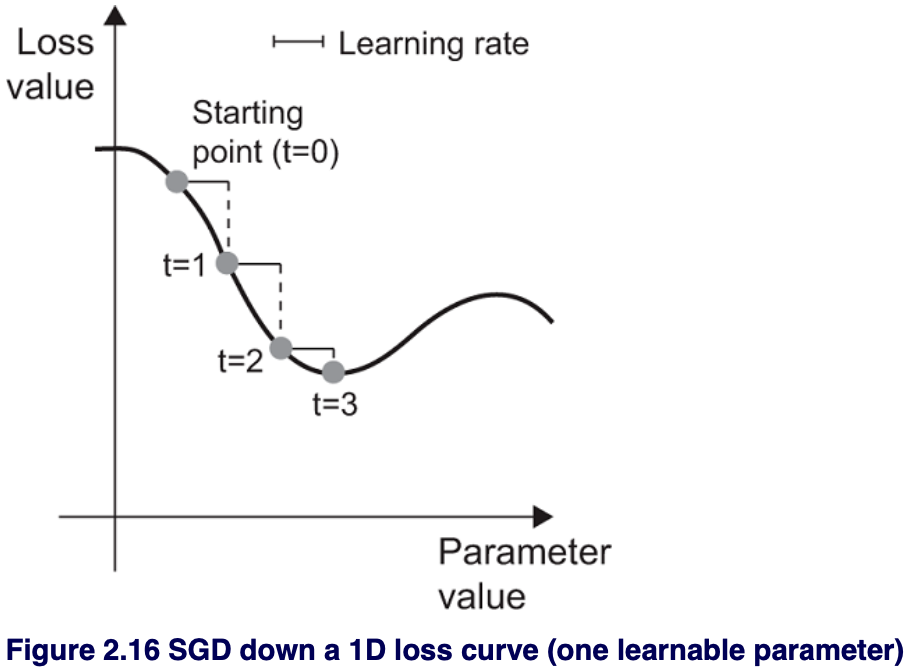

如您所见，直观地说，为learning_rate因子选择一个合理的值很重要。如果它太小，沿着曲线下降将需要许多迭代，并且它可能会卡在本地最小值。如果learning_rate太大，您的更新最终可能会将您带到曲线上完全随机的位置。

请注意，mini-batch SGD算法的一个变体是在每次迭代时采样单个样本和目标，而不是采样一批数据。这将是真正的SGD（而不是 mini-batch SGD）。或者，走到相反的极端，您可以在所有可用数据上运行每个步骤，这被称为 batch SGD。然后，每次更新都会更准确，但要贵得多。这两个极端之间的有效妥协是使用尺寸合理的 mini-batch。

虽然上图说明了1D参数空间中的梯度下降，但在实践中，您将在高维空间中使用梯度下降：神经网络中的每个权重系数都是空间中的自由维度，可能有数万甚至数百万个。为了帮助您建立关于损失表面的直觉，您还可以可视化沿着2D损失表面的梯度下降，如下图所示。但你不可能想象训练神经网络的实际过程是什么样子的——你不能以对人类有意义的方式代表一个100万维的空间。因此，最好记住，您通过这些低维表示形成的直觉在实践中可能并不总是准确的。这在历史上一直是深度学习研究领域问题的根源。

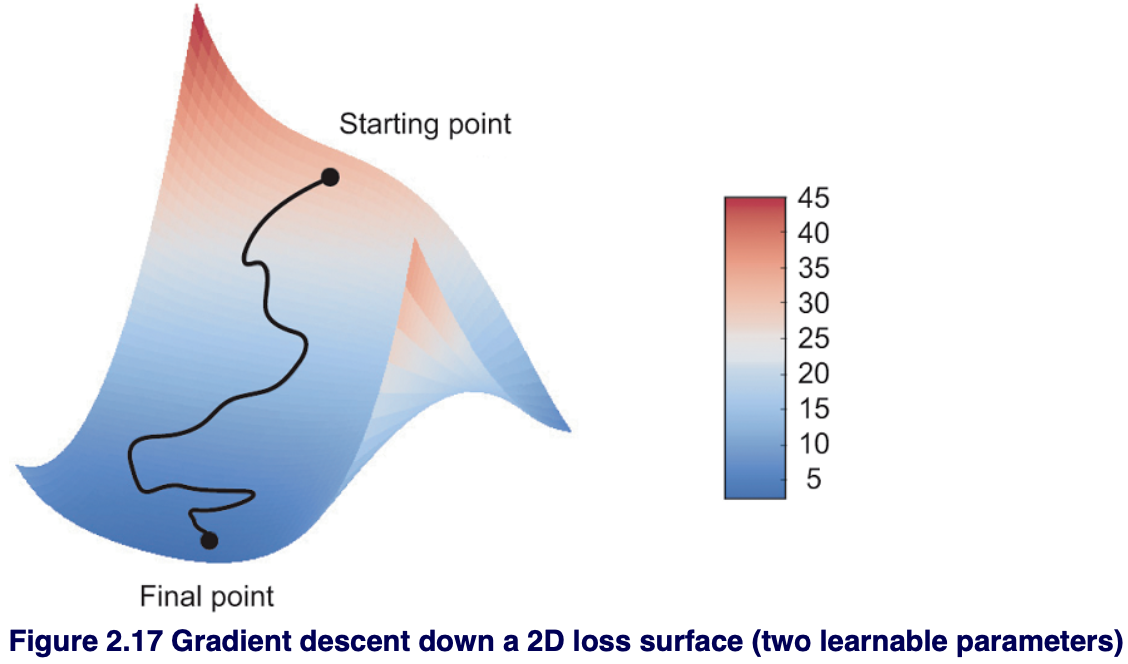

此外，在计算下一个权重更新时，SGD存在多个变体，它们通过考虑之前的权重更新而有所不同，而不仅仅是查看梯度的当前值。例如，有动量的SGD，以及Adagrad、RMSProp和其他几个。这种变体被称为优化方法或优化器。特别是，许多这些变体中使用的动量概念值得您关注。Momentum解决了SGD的两个问题：收敛速度和局部最小值。考虑图2.13，该图显示了损失曲线作为模型参数的函数。

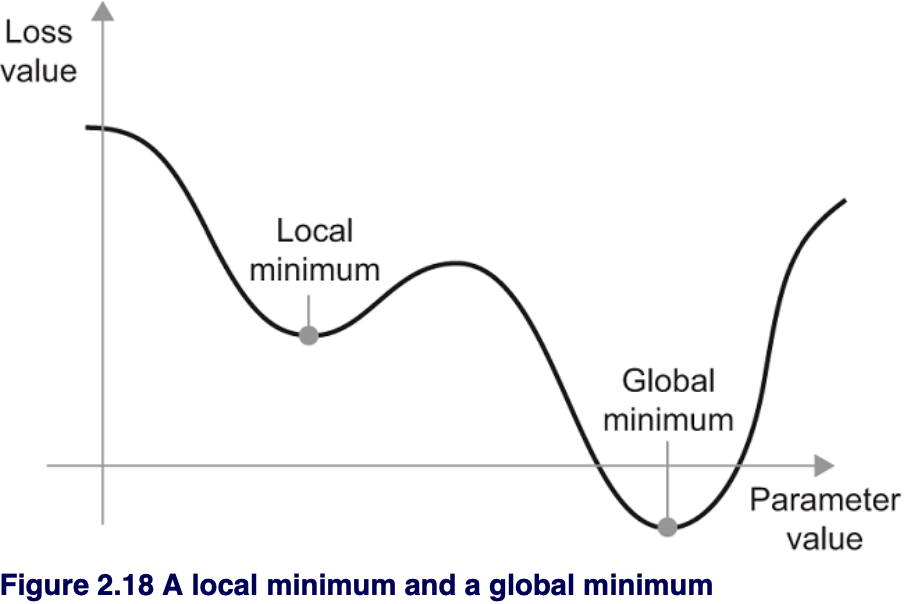

如您所见，围绕某个参数值，有一个局部最小值：在该点周围，向左移动将导致损失增加，但向右移动也会导致损失增加。如果参数正在通过学习率较小的SGD进行优化，然后优化过程将卡在局部最小值，而不是达到全局最小值。

你可以通过使用动量来避免这些问题，动量从物理学中汲取灵感。这里一个有用的 mental 图像是将优化过程视为一个沿着损失曲线滚动的小球。如果有足够的动量，球就不会卡在峡谷中，最终将达到全局最小值。动量是通过在每个步骤移动球来实现的，不仅基于当前斜率值（当前加速度），还基于当前速度（由过去加速度的结果）。在实践中，这意味着不仅根据当前梯度值，而且根据之前的参数更新更新参数w，例如在这个朴素的实现中：

```python
past_velocity = 0.
momentum = 0.1
while loss > 0.01:
    w, loss, gradient = get_current_parameters()
    velocity = past_velocity * momentum - learning_rate * gradient
    w = w + momentum * velocity - learning_rate * gradient
    past_velocity = velocity
    update_parameter(w)
```

## 2.4.4 Chaining derivatives: the Backpropagation algorithm

在上面的算法中，我们随意地假设，由于函数是可微的，我们可以很容易地计算其梯度。但这是真的吗？在实践中，我们如何计算复杂表达式的梯度？在我们的双层网络示例中，我们如何获得重量损失的梯度？这就是反向传播算法的作用所在。

### THE CHAIN RULE

反向传播是一种使用简单运算（如加法、relu或张量积）的导数来轻松计算这些原子运算任意复杂组合的梯度的方法。至关重要的是，神经网络由许多串联在一起的张量运算组成，每个运算都有一个简单、已知的导数。例如，我们第一个示例中的模型可以表示为由变量W1、b1、W2和b2参数化的函数（分别位于第一个和第二个密度层之上），涉及原子运算点积、relu、softmax和+，以及我们的损失函数损失，这些都很容易求导：

```python
loss_value = loss(y_true, softmax(dot(W2, relu(dot(W1, inputs) + b1)) + b2))
```

微积分告诉我们，可以使用以下标识（称为链规则）导出这样的函数链：

考虑两个函数 $f$ 和 $g$，以及组合函数 $fg$ ，以便 $y = fg(x) == f(fg(x))$：

```python
def fg(x):
  x1 = g(x)
  y = f(x1)
  return y
```

然后链式法则声明 grad(y, x) == grad(y, x1) * grad(x1, x)。这使您能够计算 fg 的导数，只要您知道 f 和 g 的导数。链式法则之所以这样命名，是因为当您添加更多中间函数时，它开始看起来像一个链：

```python
def fghj(x):
  x1 = j(x)
  x2 = h(x1)
  x3 = g(x2)
  y = f(x3)
  return y
grad(y, x) == grad(y, x3) * grad(x3, x2) * grad(x2, x1) * grad(x1, x)
```

将链式法则应用于神经网络梯度值的计算会产生一种名为反向传播的算法。具体来说，让我们看看这是如何运作的。

### AUTOMATIC DIFFERENTIATION WITH COMPUTATION GRAPHS

思考反向传播的一个有用方法是计算图。计算图是TensorFlow的核心数据结构，也是一般的深度学习革命。这是一个有向无环运算图——就我们而言，是张量运算。例如，这是我们第一个模型的图形表示：

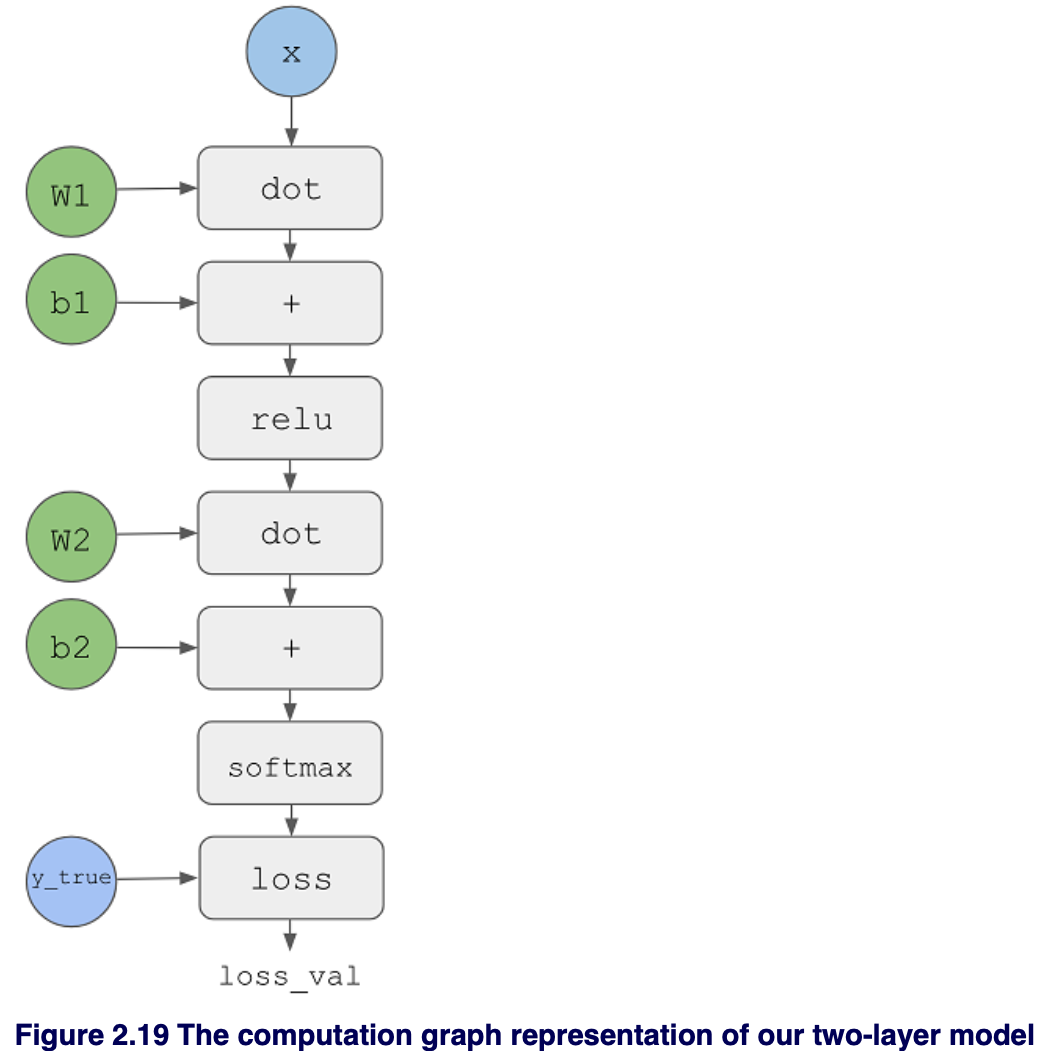

计算图在计算机科学中是一个非常成功的抽象，因为它们使我们能够将计算视为数据：可计算表达式被编码为机器可读数据结构，可以用作另一个程序的输入或输出。例如，您可以想象一个程序接收计算图并返回一个新的计算图，该计算图实现同一计算的大规模分布式版本——这意味着您可以分发任何计算，而无需自己编写分发逻辑。或者想象一下......一个接收计算图并可以自动生成它所代表的表达式导数的程序。如果您的计算以显式图数据结构表示，而不是例如.py文件中的ASCII字符行，那么做这些事情要容易得多。

为了清楚地解释反向传播，让我们看看计算图的一个真正基本的例子。我们将考虑上图的简化版本，其中我们只有一个线性层，所有变量都是标量。我们将使用两个标量变量w，b，一个标量输入x，并应用一些操作来组合成输出y。最后， 我们将应用绝对误差损失函数: `loss_val = abs(y_true - y)` 。 由于我们希望以最小化`loss_val` 的方式更新 `w` 和 `b` ，我们对计算 `grad(loss_val，b)` 和 `grad(loss_val，w)` 感兴趣。

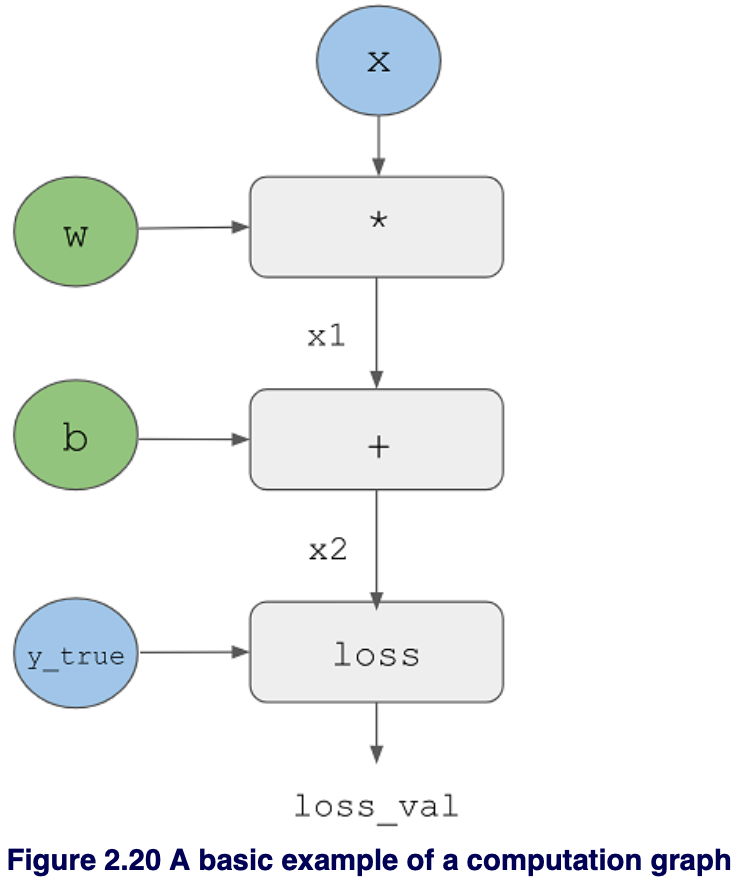

让我们为 graph x 中的“输入节点”设置具体值，即输入x、目标y_true、w和b。我们从上到下将这些值传播到图表中的所有节点，直到我们达到 `loss_val`。这是 *forward pass*。

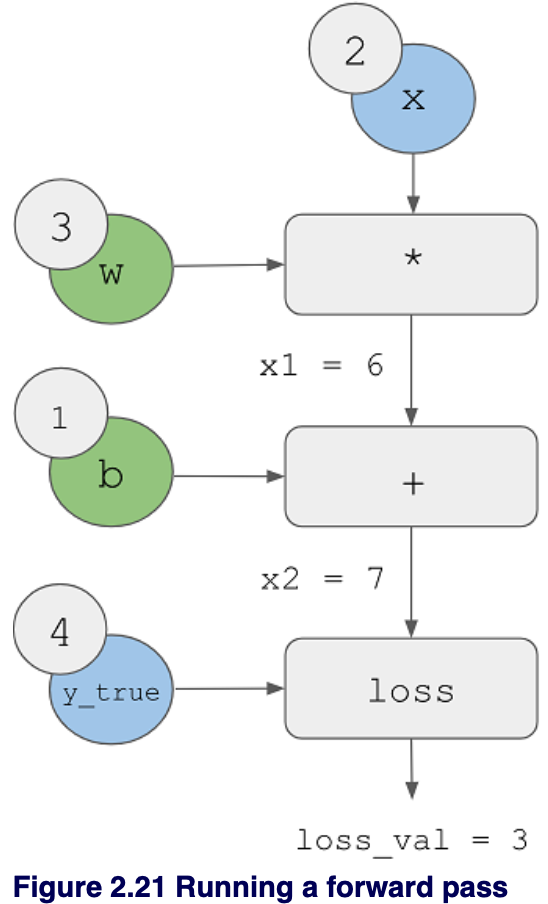

现在让我们“反转” graph ：对于 graph 中从a到b的每个边，我们将创建一个从b到a的相反的边，并询问“当a变化时，b会变化多少”？也就是说，什么是 grad(b，a)？我们将用这个值注释每个相反的边。这个 backward graph 代表 *backward pass*。

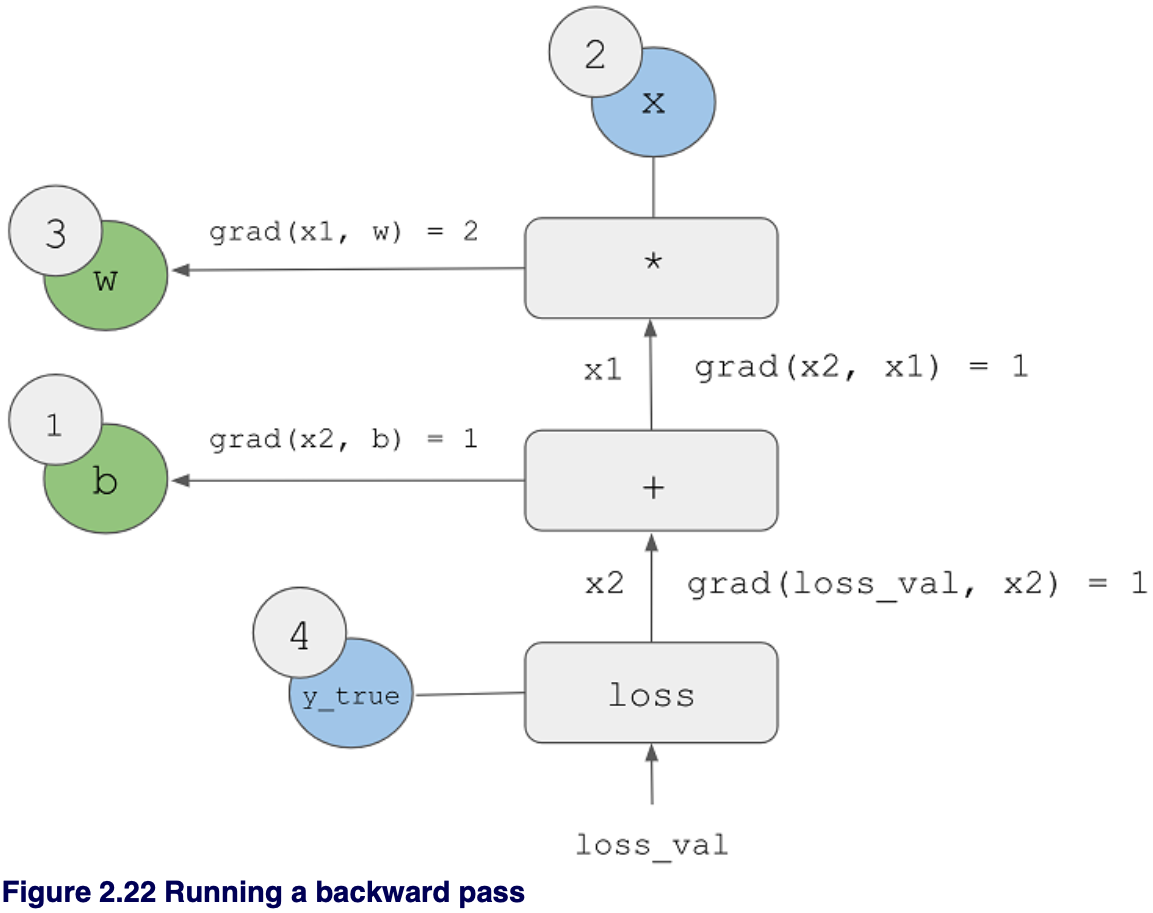

对这个backward graph，由链式法则可知， 您可以通过沿着连接两个节点的路径将每个边的导数乘以来获得一个节点相对于另一个节点的导数。例如，grad(loss_val, w) = grad(loss_val, x2) * grad(x2, x1) * grad(x1, w)。

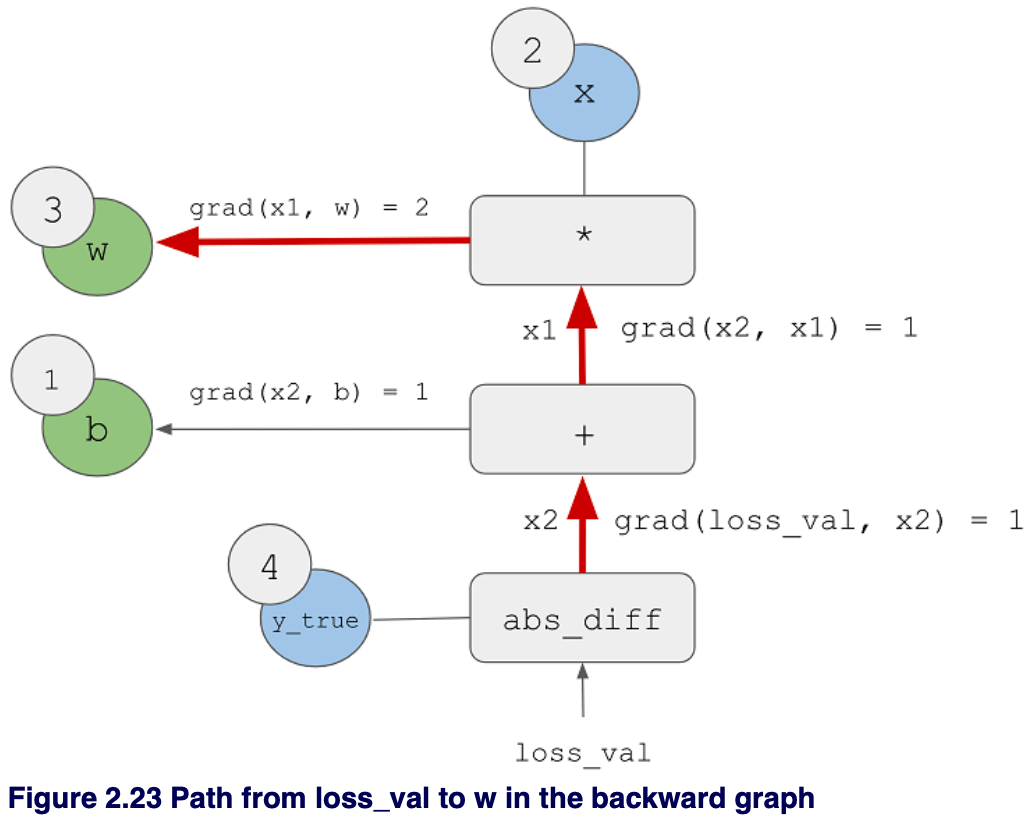

通过将链式法则应用于我们的 graph，我们得到了我们想要的东西：

- grad(loss_val, w) = 1 * 1 * 2 = 2
- grad(loss_val, b) = 1 * 1 = 1

有了它，你刚刚看到了反向传播！反向传播只是链式在计算图中的应用。没什么可说的了。反向传播从最终损失值开始，从顶层向后工作到底层，计算每个参数在损失值中的贡献。这就是“反向传播”这个名字的来源：我们在计算图中“反向传播”不同节点的损失贡献。

如今，在未来几年里，人们在能够自动微分的现代框架中实施神经网络，如TensorFlow。使用上述计算图实现自动微分。自动微分使检索可微张量运算的任意组合的梯度成为可能，除了写下正向传递外， 无需做任何额外的工作。当我用 C 在 2000 年写了我的第一个神经网络时， 我手写了我的梯度。 现在，多亏了现代自动微分工具，您永远不必自己实现反向传播。认为自己很幸运！

### THE GRADIENT TAPE IN TENSORFLOW

您可以利用TensorFlow强大的自动微分功能的API是 `GradientTape`。这是一个Python scope，将以计算图（有时称为“tape”）的形式“recored”其中运行的张量操作。然后，此 graph 可用于检索任何变量或变量集（`tf.Variable` 类的实例）的任何输出的梯度。`tf.Variable` 是保持可变状态的特定张量的方式——例如，神经网络的权重始终是tf.Variable实例。

In [67]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
    
grad_of_y_wrt_x = tape.gradient(y, x)

- 实例化标量变量，初始值为0
- 打开一个 `GradientTape` scope
- 在 scope 内，将一些张量运算应用于我们的变量
- 使用 tape 检索输出y相对于我们变量x的梯度

`GradientTape` 对张量操作有效：

In [68]:
x = tf.Variable(tf.random.uniform((2, 2)))
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

- 用形状（2，2）和初始值全零实例化 `Variable`
- Grad_of_y_wrt_x是一个形状（2，2）的张量（如x），描述了 Y = 2 * a + 3 在 x = [[0, 0], [0, 0]] 周围的曲率

它也可以作用于一组变量

In [71]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2, )))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(W, x) + b

grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

- grad_of_y_wrt_W_and_b是两个张量的列表，形状分别与W和b相同

您将在下一章中了解 gradient tape。

# Looking back at our first example

您即将结束本章，您现在应该大致了解神经网络的幕后情况了。本章开头的一个神奇的黑匣子变成了一幅更清晰的画面，如下图所示：该模型由链接在一起的层组成，将输入数据映射到预测中。然后，损失函数将这些预测与目标进行比较，产生一个损失值：衡量模型预测与预期匹配的程度。优化器使用此损失值来更新模型的权重。

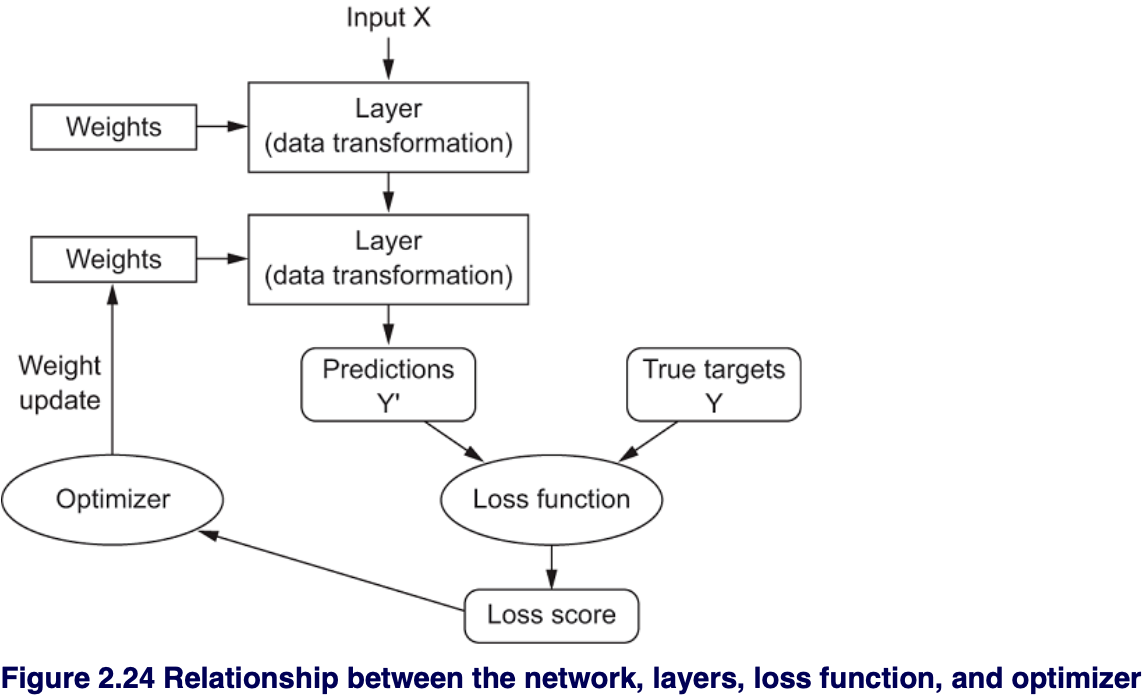

让我们回到第一个示例，并根据您在前几节中学到的知识回顾其中的每一部分。

这是输入数据：

In [72]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

现在您已经了解到，输入图像存储在NumPy张量中，NumPy张量在这里分别格式化为float32形状张量（60000、784）（训练数据）和（10000、784）（测试数据）。

这是我们的模型：

In [73]:
model = models.Sequential([
  layers.Dense(512, activation='relu'),
  layers.Dense(10, activation='softmax')
])

现在您已经知道，该模型由两个 Dense 层组成的链，每个层对输入数据应用几个简单的张量操作，这些操作涉及权重张量。权重张量是层的属性，是模型知识持续存在的地方。

这是模型编译步骤：

In [74]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

现在您已经明白了sparse_categorical_crossentropy是一个损失函数，用作学习权重张量的反馈信号，训练阶段将尝试将其最小化。您还知道，这种损失的减少是通过mini-batch SGD 实现的。管理梯度下降特定使用的确切规则由作为第一个参数传递的rmsprop优化器定义。

最后是我们的训练循环：

In [75]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
  9/469 [..............................] - ETA: 2s - loss: 1.3419 - accuracy: 0.5894  

2022-01-15 02:22:49.749038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 3s 6ms/step - loss: 0.2587 - accuracy: 0.9242
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1046 - accuracy: 0.9694
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0695 - accuracy: 0.9790
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0497 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0376 - accuracy: 0.9883


现在您了解了当您调用fit时会发生什么：模型将开始以128个样本的 mini-batch 迭代训练数据，重复5次（所有训练数据的每次迭代都称为epoch）。对于每批，模型将计算权重损失的梯度（使用反向传播算法，该算法源于微积分中的链式法额），并将权重向减少该批损失值的方向移动。

在这5个 epoch 之后，模型将进行2345次梯度更新（每个epoch 469次），模型的损失将足够低，以至于模型将能够高精度地对手写数字进行分类。

在这一点上，你已经知道了神经网络的大部分知识。让我们一步一步地在TensorFlow中“从头开始”重新实现第一个示例的简化版本来证明这一点。

## 2.5.1 Reimplementing our first example from scratch in TensorFlow

有什么比从头开始实现一切更好的是展示充分、明确的理解呢？当然，“从头开始”在这里意味着相对的：我们不会重新实现基本张量运算，也不会实现反向传播。但我们将达到如此低的水平，以至于我们几乎不会使用任何Keras函数。

如果你还不明白这个例子中的每一个细节，别担心。下一章将更详细地探讨TensorFlow API。目前，只需尝试遵循正在发生的事情的要点——本示例的目的是帮助您使用具体实现实现对深度学习数学的理解。我们走吧！

### A SIMPLE DENSE CLASS

您之前已经了解到，Dense 层实现以下输入变换，其中W和b是模型参数，激活是一个element-wise 函数（通常relu，但最后一个层是softmax）：

```python
output = activation(dot(W, input) + b)
```

让我们实现一个简单的Python类NaiveDense，该类创建了两个TensorFlow变量W和b，并公开了应用上述变换的调用方法。

In [102]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation
        
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval = 1e-1)
        self.W = tf.Variable(w_initial_value)
        
        b_shape = (output_size, )
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)
        
    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]
    

- 创建一个形状“（input_size， output_size）”的矩阵W，用随机值初始化。
- 创建形状（output_size, ）的矢量b，用零初始化。
- 应用前向过程
- 检索 graph 权重的方便方法。

### A SIMPLE SEQUENTIAL CLASS

现在，让我们创建一个 NaiveSequential 类来链接这些层。它封装了一个 graph 列表，并公开了一个调用方法，只需按顺序调用输入上的底层 graph。它还具有权重属性，可以轻松跟踪 graph 的参数。

In [103]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

使用此 `NaiveDense` 类和 `NaiveSequential` 类，我们可以创建一个模拟Keras模型：

In [104]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

### A BATCH GENERATOR

接下来，我们需要一种以mini-batch 迭代MNIST数据的方法。这很容易：

In [105]:
class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

## 2.5.2 Running one training step

流程中最困难的部分是“训练步骤”：在对一批数据上运行模型后更新模型的权重。我们需要：

- 计算对于批量中的图像， 模型的预测结果
- 计算预测结果与给定标签的损失值
- 计算对于模型权重的损失值的梯度
- 向梯度相反方向移动一点权重

为了计算梯度，我们将使用 TensorFlow `GradientTape` 对象。像这样：

In [106]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

- 运行“forward pass”（在 `GradienTape` scope 内计算模型的预测）
- 计算损失与权重的梯度。输出梯度是一个列表，其中每个条目对应于model.weights列表中的权重。
- 使用梯度更新权重（我们将在下面定义此函数）

如您所知，“权重更新”步骤（由update_weights函数表示）的目的是将权重按“a bit”移动，以减少此批次的损失。移动的规模由“learning rate”决定，通常是少量。实现此 update_weights 函数的最简单方法是从每个权重中减去 gradient * learning_rate：

In [107]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, model.weights):
        w.assign_sub(w * learning_rate)

- 对于 TensorFlow 变量 `assign_sub` 等价于 -= 

在实践中，您几乎永远不会手动实现这样的权重更新步骤。相反，你将使用Keras的优化器实例。像这样：

In [111]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

现在我们的每批量训练步骤已经准备就绪，我们可以将一个步骤移到实施整个训练 epoch。

## 2.5.3 The full training loop

训练 epoch 只是重复训练数据中每个批量的训练步骤，而完整的训练循环只是重复一个epoch：

In [112]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print("Epoch %d" % epoch_counter)
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(len(images) // batch_size):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print('loss at batch %d: %.2f' % (batch_counter, loss))

让我们来测试一下它：

In [113]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 4.94
loss at batch 100: 2.26
loss at batch 200: 2.22
loss at batch 300: 2.11
loss at batch 400: 2.19
Epoch 1
loss at batch 0: 1.94
loss at batch 100: 1.90
loss at batch 200: 1.84
loss at batch 300: 1.73
loss at batch 400: 1.82
Epoch 2
loss at batch 0: 1.61
loss at batch 100: 1.59
loss at batch 200: 1.53
loss at batch 300: 1.45
loss at batch 400: 1.51
Epoch 3
loss at batch 0: 1.33
loss at batch 100: 1.35
loss at batch 200: 1.26
loss at batch 300: 1.23
loss at batch 400: 1.28
Epoch 4
loss at batch 0: 1.12
loss at batch 100: 1.17
loss at batch 200: 1.06
loss at batch 300: 1.06
loss at batch 400: 1.11
Epoch 5
loss at batch 0: 0.97
loss at batch 100: 1.02
loss at batch 200: 0.92
loss at batch 300: 0.94
loss at batch 400: 0.99
Epoch 6
loss at batch 0: 0.86
loss at batch 100: 0.91
loss at batch 200: 0.81
loss at batch 300: 0.85
loss at batch 400: 0.90
Epoch 7
loss at batch 0: 0.77
loss at batch 100: 0.83
loss at batch 200: 0.73
loss at batch 300: 0.77
loss at batch 40

## 2.5.4 Evaluating the model

我们可以通过对测试图像进行预测的argmax并将其与预期标签进行比较来评估模型：

In [116]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print('accuracy: %.2f' % np.mean(matches))

accuracy: 0.84


- 在TensorFlow张量上调用.numpy()会将其转换为NumPy张量

都完成了！如您所见，“手工”在几行Keras代码中可以做的事情是相当多的工作。但是，由于您已经完成了这些步骤，因此当您调用fit()时，您现在应该对神经网络内部发生的事情有一个清晰的了解。拥有这种低级的代码在幕后操作的 mental 模型，将使您能够更好地利用Keras API的高级功能。

# 2.6 Chapter summary

- 张量构成了现代机器学习系统的基础。它们有各种各样的dtype、秩和形状。
- 您可以通过张量运算（如加法、张量积或元素乘法）来操作数值张量，这可以解释为几何变换编码。一般来说，深度学习中的一切都适合几何解释。
- 深度学习模型由简单的张量运算链组成，由权重参数化，权重本身就是张量。模型的权重是其“知识”的存储位置。
- 学习意味着为模型的权重找到一组值，以最小化给定训练数据样本集及其相应目标的损失函数。
- 学习是通过随机采样数据样本及其标签，并计算模型参数相对于批次损失的梯度来实现的。然后，模型参数与梯度相反的方向移动一点（移动的大小由学习速率定义）。这被称为小批量梯度下降。
- 神经网络中的所有张量运算都是可微的，因此可以应用链式法则来找到将当前参数和当前数据批映射到梯度值的梯度函数，因此整个学习过程成为可能。这被称为反向传播。
- 您在未来章节中经常看到的两个关键概念是损失和优化器。在开始将数据输入模型之前，您需要定义以下两件事。
- - 损失是您在训练期间试图最小化的值，因此它应该代表您试图解决的任务的成功衡量标准。
- - 优化器指定了损失梯度用于更新参数的确切方式：例如，它可以是RMSProp优化器、带动量的SGD等。